# Problem 2: Optimizing the quantity of ingredients to order

#### Summary:
We performed A/B testing on our linear model and our flask proof of concept with a size of 100 people consisting of our group's family and friends. We then curated their responses and stored it in the dataset "demand_menu.csv". As
a result of our solution, we expect drastic changes to the overall demand of salad ingredients to Salad Stop. As a 
result, Salad Stop would need to be able to adjust the quantity of ingredients to be purchased based on the fluctuations in demand. As a result, we propose a long-short term memory neural network to study our time-series dataset "demand_menu.csv". Using this model, we predict and forecast future demand of each ingredient. We will then feed this to our stochastic model created based on historical demand and ingredient statistics (e.g. cost, price, space taken up) which will then optimize the optimal number of ingredients to order and the corresponding expected profits 

## Descriptive Analytics

In this section, we will perform data visualisations to observe the trends of different quantities of each ingredient being ordered at salad stop at a particular store in a particular day

In [103]:
"""
Import Libraries
"""

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [112]:
"""
Import dataset and formatting
"""

ingredient_demand = pd.read_csv("../data/demand_kaggle.csv", index_col=0)
# ingredient_demand_transform = ingredient_demand.set_index('Date')
ingredient_demand_transform = ingredient_demand
ingredient_demand_transform.head()

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,33,33,15,10,11,23,25,10,18,37,...,34,17,30,22,37,23,28,49,16,21
2013-01-02,37,43,30,11,6,6,23,11,23,34,...,30,25,19,22,30,6,26,48,13,28
2013-01-03,38,23,14,8,8,15,34,8,25,32,...,35,25,33,30,40,15,38,45,12,40
2013-01-04,54,18,10,19,9,13,36,19,22,45,...,46,27,24,24,48,13,38,41,23,45
2013-01-05,51,34,23,12,8,15,38,12,29,35,...,43,22,32,28,31,15,45,48,23,38


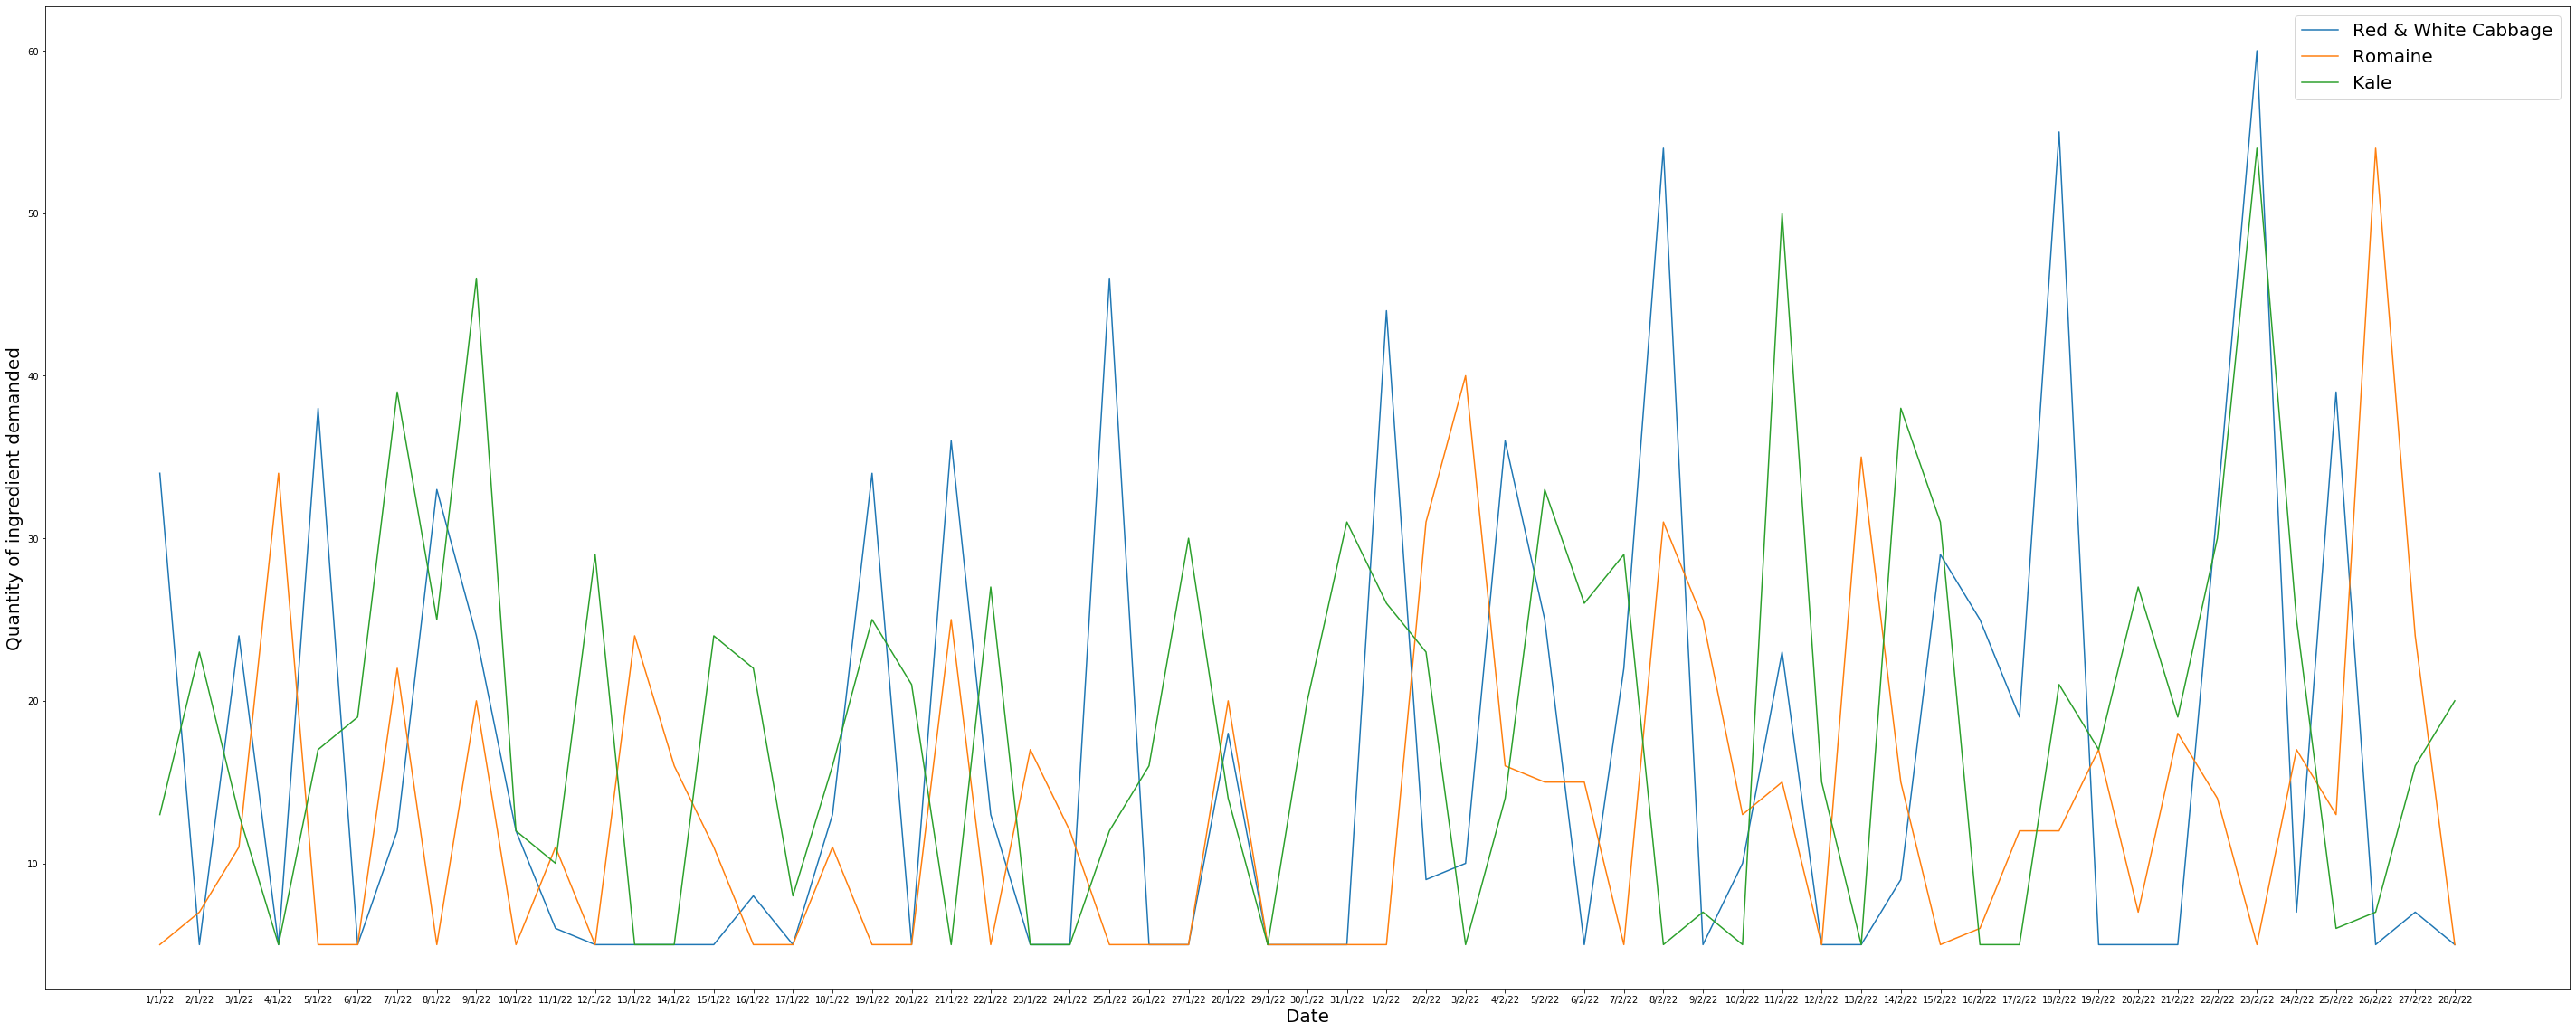

In [113]:
"""
Visualize demand for some ingredients
"""

pyplot.figure(figsize=(50,20))

for i, c in enumerate(ingredient_demand_transform.columns):
    if i == 3:
        break
    pyplot.plot(ingredient_demand_transform[c], label=c)

pyplot.ylabel('Quantity of ingredient demanded',size=20)
pyplot.xlabel('Date',size=20)
pyplot.legend(loc='upper right',fontsize=20)

pyplot.show()

## Predictive Analytics

In this section, we will perform data visualisations to observe the trends of different quantities of each ingredient being ordered at salad stop at a particular store in a particular day

In [4]:
"""
Normalize Dataset
"""

scaler = MinMaxScaler(feature_range=(0, 1))


def normalize(scaler, original, reference):
    original_inverse = scaler.fit_transform(original)
    original_inverse_df = pd.DataFrame(original_inverse)
    original_inverse_df.index = reference.index
    original_inverse_df.columns = reference.columns
    return original_inverse_df


def invert_normalize(scaler, original, reference):
    original_inverse = scaler.inverse_transform(original)
    original_inverse_df = pd.DataFrame(original_inverse)
    original_inverse_df.index = reference.index
    original_inverse_df.columns = reference.columns
    return original_inverse_df


ingredient_demand_transform_inverse = normalize(scaler, ingredient_demand_transform, ingredient_demand_transform)
ingredient_demand_transform_inverse.head()

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.079646,0.196078,0.112903,0.153846,0.235294,0.418605,0.108911,0.153846,0.0500,0.182609,...,0.142857,0.067797,0.164835,0.132353,0.14,0.418605,0.084211,0.196850,0.148148,0.015267
2013-01-02,0.115044,0.294118,0.354839,0.179487,0.088235,0.023256,0.089109,0.179487,0.1125,0.156522,...,0.104762,0.203390,0.043956,0.132353,0.07,0.023256,0.063158,0.188976,0.092593,0.068702
2013-01-03,0.123894,0.098039,0.096774,0.102564,0.147059,0.232558,0.198020,0.102564,0.1375,0.139130,...,0.152381,0.203390,0.197802,0.250000,0.17,0.232558,0.189474,0.165354,0.074074,0.160305
2013-01-04,0.265487,0.049020,0.032258,0.384615,0.176471,0.186047,0.217822,0.384615,0.1000,0.252174,...,0.257143,0.237288,0.098901,0.161765,0.25,0.186047,0.189474,0.133858,0.277778,0.198473
2013-01-05,0.238938,0.205882,0.241935,0.205128,0.147059,0.232558,0.237624,0.205128,0.1875,0.165217,...,0.228571,0.152542,0.186813,0.220588,0.08,0.232558,0.263158,0.188976,0.277778,0.145038


In [5]:
"""
Train-test split while maintaining chronology and sequence
"""

train_size = int(int(len(ingredient_demand_transform_inverse)) * 0.7)
test_size = len(ingredient_demand_transform_inverse) - train_size
v_train_size = int(train_size * 0.7)
v_validation_size = train_size - v_train_size

train = ingredient_demand_transform_inverse.iloc[0:v_train_size, :]
valid = ingredient_demand_transform_inverse.iloc[v_train_size:train_size, :]
test = ingredient_demand_transform_inverse.iloc[train_size:, :]

In [6]:
"""
Time series generators
"""

NUMBER_OF_DATA_POINTS_FROM_DATA_SET = 5
NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH = 5
NUMBER_OF_FEATURES = ingredient_demand_transform_inverse.shape[1]

train_generator = TimeseriesGenerator(train.to_numpy(), train.to_numpy(), length=NUMBER_OF_DATA_POINTS_FROM_DATA_SET, batch_size=NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH)
validator_generator = TimeseriesGenerator(valid.to_numpy(), valid.to_numpy(), length=NUMBER_OF_DATA_POINTS_FROM_DATA_SET, batch_size=NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH)
test_generator = TimeseriesGenerator(test.to_numpy(), test.to_numpy(), length=NUMBER_OF_DATA_POINTS_FROM_DATA_SET, batch_size=NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH)

In [7]:
"""
LSTM Neural Network Generation
"""

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dropout(0.15))
# model.add(Dense(87))

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(NUMBER_OF_DATA_POINTS_FROM_DATA_SET,NUMBER_OF_FEATURES),return_sequences=True))
# model.add(LSTM(100,activation='relu',return_sequences=True))
# model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(87))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(train_generator,epochs=100,verbose=1,validation_data=validator_generator)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/5 [=====>........................] - ETA: 11s - loss: 0.1286WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fac45de8f80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full out

Epoch 65/100
5/5 [==============================] - 0s 71ms/step - loss: 0.0556 - val_loss: 0.0734
Epoch 66/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0580 - val_loss: 0.0735
Epoch 67/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0589 - val_loss: 0.0736
Epoch 68/100
5/5 [==============================] - 0s 64ms/step - loss: 0.0562 - val_loss: 0.0735
Epoch 69/100
5/5 [==============================] - 0s 107ms/step - loss: 0.0585 - val_loss: 0.0732
Epoch 70/100
5/5 [==============================] - 0s 77ms/step - loss: 0.0588 - val_loss: 0.0747
Epoch 71/100
5/5 [==============================] - 0s 96ms/step - loss: 0.0559 - val_loss: 0.0732
Epoch 72/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0586 - val_loss: 0.0733
Epoch 73/100
5/5 [==============================] - 0s 71ms/step - loss: 0.0590 - val_loss: 0.0736
Epoch 74/100
5/5 [==============================] - 0s 45ms/step - loss: 0.0567 - val_loss: 0.0732
Epoch 75/

In [8]:
"""
We will use N consecutive datapoints from the original dataset, to predict the next datapoint and store it in PREDICTION_LIST
"""

FIRST_INDEX = 0
PREDICTION_LIST = []
PREDICTION_POINTS = ingredient_demand_transform_inverse[FIRST_INDEX:FIRST_INDEX+NUMBER_OF_DATA_POINTS_FROM_DATA_SET].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))

for i in range(NUMBER_OF_DATA_POINTS_FROM_DATA_SET, len(ingredient_demand_transform_inverse)):   
    PREDICTION_LIST.append(model.predict(PREDICTION_POINTS)[0]) 
    FIRST_INDEX += 1
    PREDICTION_POINTS = ingredient_demand_transform_inverse[FIRST_INDEX:FIRST_INDEX+NUMBER_OF_DATA_POINTS_FROM_DATA_SET].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))
    
    
PREDICTION_LIST_DF = pd.DataFrame(PREDICTION_LIST)
PREDICTION_LIST_DF.columns = ingredient_demand_transform_inverse.columns

EMPTY_DF = pd.DataFrame([[np.nan] * len(ingredient_demand_transform_inverse.columns)] * NUMBER_OF_DATA_POINTS_FROM_DATA_SET, columns=ingredient_demand_transform_inverse.columns)
PREDICTION_LIST_DF = EMPTY_DF.append(PREDICTION_LIST_DF)
PREDICTION_LIST_DF.tail()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
49,0.135379,0.141234,0.163013,0.164607,0.197781,0.073174,0.237996,0.203830,0.231767,0.213994,...,0.140859,0.151735,0.138409,0.057735,0.082301,0.101817,0.161451,0.313351,0.168058,0.151742
50,0.113079,0.075870,0.264301,0.212138,0.093897,0.036384,0.277523,0.112792,0.232826,0.214053,...,0.226854,0.142359,0.163389,0.070759,0.081889,0.170410,0.172507,0.260706,0.116885,0.258916
51,0.097696,0.115244,0.249244,0.151467,0.178568,0.055191,0.218980,0.140522,0.201351,0.172950,...,0.252665,0.116222,0.248014,0.036966,0.051104,0.133126,0.143794,0.357658,0.142639,0.174627
52,0.121076,0.118312,0.283584,0.183753,0.150189,0.049935,0.167505,0.164565,0.222373,0.188568,...,0.254980,0.116791,0.276288,0.053351,0.071641,0.130501,0.164479,0.348969,0.182522,0.219271
53,0.148296,0.094471,0.318942,0.268415,0.253652,0.103737,0.058314,0.205500,0.136956,0.197042,...,0.359185,0.108492,0.436945,0.059759,0.071212,0.115244,0.132303,0.380374,0.310062,0.213251


In [9]:
"""
Model evaluation using RMSE metric
"""

print(f"Train set RMSE for all ingredients: {np.sqrt(np.mean((np.array(PREDICTION_LIST_DF[NUMBER_OF_DATA_POINTS_FROM_DATA_SET:v_train_size])-np.array(train[NUMBER_OF_DATA_POINTS_FROM_DATA_SET:]))**2))}")
print(f"Validation set RMSE for all ingredients: {np.sqrt(np.mean((np.array(PREDICTION_LIST_DF[v_train_size:train_size])-np.array(valid))**2))}")
print(f"Train set RMSE for all ingredients: {np.sqrt(np.mean((np.array(PREDICTION_LIST_DF[train_size:])-np.array(test))**2))}")

Train set RMSE for all ingredients: 0.22082746517351914
Validation set RMSE for all ingredients: 0.2712307337652893
Train set RMSE for all ingredients: 0.27152671880304796


In [10]:
"""
Reverse min-max scaler on prediction dataframe
"""

prediction_inverse = invert_normalize(scaler, PREDICTION_LIST_DF, ingredient_demand_transform)
prediction_inverse.tail()

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
24/2/22,12.445868,11.920466,12.987616,13.559553,17.064641,10.634404,18.089796,16.006815,18.674241,19.337569,...,12.888092,12.738491,10.951579,8.925953,10.678764,9.989029,16.463022,23.487701,12.730659,11.676637
25/2/22,11.219351,8.717639,17.950727,16.031195,10.727703,7.801555,20.263764,11.090758,18.736735,19.341547,...,17.703802,12.260284,12.025732,9.811628,10.650355,13.350098,17.247998,20.381628,10.376733,16.392305
26/2/22,10.373259,10.646938,17.212964,12.876296,15.892654,9.249733,17.043886,12.588178,16.879718,16.587681,...,19.149234,10.927332,15.664610,7.513686,8.526175,11.523186,15.209359,26.101806,11.561416,12.683595
27/2/22,11.659196,10.797276,18.895631,14.555168,14.161524,8.844970,14.212783,13.886523,18.120036,17.634024,...,19.278902,10.956347,16.880379,8.627850,9.943245,11.394545,16.678029,25.589144,13.396008,14.647927
28/2/22,13.156284,9.629072,20.628156,18.957562,20.472765,12.987750,8.207245,16.096975,13.080385,18.201795,...,25.114376,10.533071,23.788632,9.063634,9.913648,10.646936,14.393482,27.442095,19.262871,14.383035


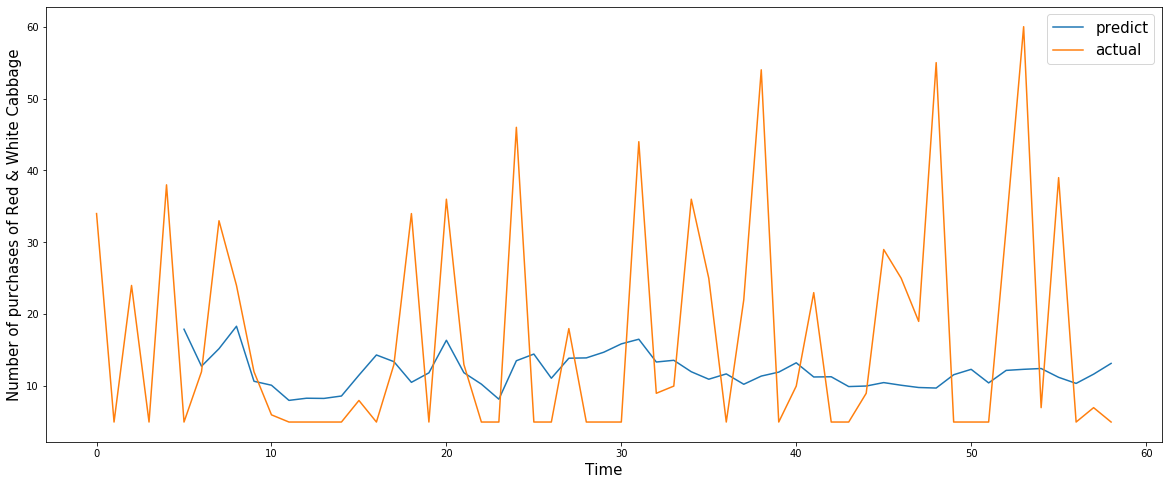

In [11]:
"""
As it is impractical to visualise all ingredients, we will pick one and observe the predicted number of ingredients 
used vs the actual number of ingredients used. Due to the fact that random number generator was used to generate the
csv files, it results in the highly skewed and inaccurate performance of the neural network.
"""

INGREDIENT_TO_EVALUATE = "Red & White Cabbage"
prediction_array = list(prediction_inverse[INGREDIENT_TO_EVALUATE])
actual_array = list(ingredient_demand_transform[INGREDIENT_TO_EVALUATE])

pyplot.figure(figsize=(20,8))
pyplot.plot(prediction_array, label='predict')
pyplot.plot(actual_array, label='actual')
pyplot.legend()

pyplot.ylabel(f'Number of purchases of {INGREDIENT_TO_EVALUATE}', size=15)
pyplot.xlabel('Time', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

In [12]:
"""
We will use the last N consecutive datapoints to predict the quantity of ingredients to import outside the dataset
"""

PREDICTION_POINTS = ingredient_demand_transform_inverse[-1 * NUMBER_OF_DATA_POINTS_FROM_DATA_SET:].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))
NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE = 10

ingredient_demand_transform_inverse_with_future = ingredient_demand_transform_inverse

for i in range(NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE):   
    PREDICTION_VALUE = model.predict(PREDICTION_POINTS)[0]
    PREDICTION_VALUE_TEMP_DF = pd.DataFrame([PREDICTION_VALUE])
    PREDICTION_VALUE_TEMP_DF.columns = ingredient_demand_transform.columns
    TEMP_FRAME = [ingredient_demand_transform_inverse_with_future, PREDICTION_VALUE_TEMP_DF]
    ingredient_demand_transform_inverse_with_future = pd.concat(TEMP_FRAME)
    PREDICTION_POINTS = ingredient_demand_transform_inverse_with_future[-1 * NUMBER_OF_DATA_POINTS_FROM_DATA_SET:].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))


ingredient_demand_transform_inverse_with_future

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/2022,0.000000,0.300000,1.000000,0.900000,0.500000,0.900000,0.900000,0.600000,0.100000,0.300000,...,0.600000,0.000000,0.600000,0.000000,0.700000,0.000000,0.500000,0.800000,1.000000,0.000000
2/1/2022,0.700000,0.500000,0.500000,1.000000,0.300000,0.900000,0.300000,0.000000,1.000000,0.400000,...,0.500000,0.600000,0.800000,0.300000,0.700000,0.600000,0.500000,0.400000,0.600000,0.100000
3/1/2022,1.000000,0.200000,0.400000,0.800000,0.300000,0.000000,0.000000,0.900000,0.400000,0.200000,...,0.900000,0.100000,0.400000,0.300000,0.500000,1.000000,0.200000,0.800000,1.000000,0.600000
4/1/2022,0.400000,1.000000,0.400000,0.900000,0.600000,0.400000,1.000000,0.400000,0.900000,0.100000,...,0.100000,0.700000,0.500000,1.000000,0.300000,0.000000,0.400000,0.700000,0.300000,0.800000
5/1/2022,0.600000,0.600000,0.800000,0.200000,0.400000,0.300000,0.100000,0.200000,1.000000,0.200000,...,0.400000,0.400000,0.700000,0.500000,0.800000,0.500000,0.500000,0.500000,0.700000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.102875,0.101161,0.227223,0.182234,0.142595,0.065047,0.120769,0.129253,0.124585,0.186890,...,0.254801,0.079884,0.271963,0.067128,0.056174,0.125037,0.155669,0.253996,0.214314,0.164964
0,0.097755,0.105383,0.211251,0.169204,0.152114,0.065180,0.118493,0.128878,0.120699,0.179122,...,0.244563,0.077005,0.266042,0.061050,0.048577,0.116778,0.150697,0.258110,0.207368,0.145820
0,0.087446,0.096245,0.211916,0.164973,0.148491,0.061044,0.115402,0.110649,0.109115,0.169325,...,0.254302,0.068932,0.271965,0.056588,0.038083,0.118588,0.145154,0.252939,0.194627,0.139969
0,0.085734,0.093757,0.205187,0.162970,0.132730,0.055601,0.135462,0.103192,0.117137,0.173208,...,0.240141,0.073052,0.244118,0.059417,0.040672,0.123836,0.149676,0.237124,0.179401,0.145580


In [13]:
ingredient_demand_transform_with_future = invert_normalize(scaler, ingredient_demand_transform_inverse_with_future, ingredient_demand_transform_inverse_with_future)
ingredient_demand_transform_with_future = ingredient_demand_transform_with_future.astype(int)
ingredient_demand_only_future = ingredient_demand_transform_with_future[-1 * NUMBER_OF_DATA_POINTS_FROM_DATA_SET:]
ingredient_demand_transform_with_future

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/2022,300,330,200,190,150,190,190,160,160,180,...,210,150,210,150,220,150,200,230,250,150
2/1/2022,370,350,150,200,130,190,130,100,250,190,...,200,210,230,180,220,210,200,190,210,160
3/1/2022,400,320,140,180,130,100,100,190,190,170,...,240,160,190,180,200,250,170,230,250,210
4/1/2022,340,400,140,190,160,140,200,140,240,160,...,160,220,200,250,180,150,190,220,180,230
5/1/2022,360,360,180,120,140,130,110,120,250,170,...,190,190,220,200,230,200,200,200,220,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,10,9,16,14,13,10,11,11,12,17,...,19,9,16,9,8,11,16,19,14,12
0,10,10,15,13,14,10,11,11,12,17,...,18,8,16,9,8,10,15,20,14,11
0,9,9,15,13,14,9,11,10,11,16,...,19,8,16,8,7,10,15,19,13,11
0,9,9,15,13,13,9,12,10,11,16,...,18,8,15,9,7,11,15,18,13,11


## Prescriptive Analytics

Given the historical demand of each ingredient, along with the necessary information of statistics such as the pricing and costing of each ingredient, we will generate a stochastic model to optimize the quantity of ingredients to be imported and ordered by Salad Stop as well as the subsequent expected amount of profits to be earned by salad stop. We will then test our stochastic model with the forecasted demand generated by our neural network. This problem is similar to the multiple items newsvendor problem, hence our stochastic model will be greatly based on it.

#### Stochastic Model:

$$
\begin{align*}
\max \ &\sum_{i = 1}^N\left( \frac{1}{K} \sum_{k = 1}^K p_i t_{ki} - c_i x_i \right) \\
{\rm s.t.}\  & t_{ki} \leq x_i & \forall i = 1,...,N, k = 1,...,K\\
&t_{ki} \leq d_{ki} & \forall i = 1,...,N, k = i,...,K\\  
&\sum_{i = 1}^N s_i x_i \leq C\\
&x_i \geq 0 & \forall i = 1,...,N 
\end{align*}
$$

In [14]:
"""
Import Libaries
"""

from rsome import ro
from rsome import grb_solver as grb
import random

In [15]:
Demand_data

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce,Placeholder
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,33,33,15,10,11,23,25,10,18,37,...,17,30,22,37,23,28,49,16,21,25
2013-01-02,37,43,30,11,6,6,23,11,23,34,...,25,19,22,30,6,26,48,13,28,23
2013-01-03,38,23,14,8,8,15,34,8,25,32,...,25,33,30,40,15,38,45,12,40,29
2013-01-04,54,18,10,19,9,13,36,19,22,45,...,27,24,24,48,13,38,41,23,45,31
2013-01-05,51,34,23,12,8,15,38,12,29,35,...,22,32,28,31,15,45,48,23,38,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,58,55,26,16,6,19,45,16,37,55,...,28,34,28,63,19,54,62,15,62,32
2017-12-28,49,50,21,20,15,20,36,20,34,63,...,31,46,37,36,20,50,58,18,57,22
2017-12-29,54,50,38,25,17,25,57,25,46,56,...,24,49,37,48,25,48,69,21,64,38


In [94]:
data1.columns

Index(['Ingredient', 'Ingredient_type', 'Price', 'Serving_size', 'COGS',
       'per (g, pcs, unit)', 'COGS_per_serving',
       'Adjusted_COGS_per_serving (if needed)', 'Calories', 'Carbohydrates',
       'Protein', 'Fat', 'Sugar', 'Sodium', 'Fibre', 'Cholestrol',
       'Carbon_footprint', 'Vegan', 'Vegetarian', 'Gluten', 'Dairy', 'Nuts',
       'Spicy', 'Sources', 'Unnamed: 24'],
      dtype='object')

In [16]:
"""
Assignment of pricing to our dataset

9.9: 2 Dressing + 7 Ingredient + 1 Standard Base
11.9: 2 Dressing + 7 Ingredient + 1 Premium Base

Assume that the price of each element is constant, hence:
1 Dressing: 0.99
1 Ingredient: 0.99
1 Standard Base: 0.99

Then Premium base would be the cost of standard base + the difference between premium base and standard base, hence:
1 Premium Base: 2.99
"""

Param_data = pd.DataFrame().assign(Ingredient=data1['Ingredient'], COGS=data1['COGS_per_serving'], Ingredient_Type=data1['Ingredient_type'], Additional_Price_For_Premium_Toppings=data1['Price'], Space = data1['Serving_size']/1000)
Param_data['Price'] = None
# Param_data['Space'] = None

for i in range(Param_data.shape[0]):
    if Param_data["Ingredient_Type"][i] in ["Standard Base", "Wrap", "Grain Bowl", "Standard Topping", "Dressing (Western)", "Dressing (Asian)"]:
        Param_data["Price"][i] = 0.99
    elif Param_data["Ingredient_Type"][i] in ["Premium Base"]:
        Param_data["Price"][i] = 2.99
    elif Param_data["Ingredient_Type"][i] in ["Premium Topping"]:
        Param_data["Price"][i] = Param_data["Additional_Price_For_Premium_Toppings"][i]
    
#     Param_data["Space"][i] = round(random.uniform(0, 1), 2)
        
Param_data = Param_data.set_index('Ingredient').T
Param_data

<ipython-input-95-b6ddcb391b60>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-95-b6ddcb391b60>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-95-b6ddcb391b60>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce,Placeholder
COGS,0.53,1.86,3.75,0.56,0.99,1.4,0.79,0.67,1.47,1.01,...,0.83,0.75,1.19,0.75,0.34,0.29,1.07,0.85,0.25,0
Ingredient_Type,Standard Base,Standard Base,Premium Base,Premium Base,Wrap,Wrap,Wrap,Wrap,Grain Bowl,Grain Bowl,...,Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Placeholder
Additional_Price_For_Premium_Toppings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Space,0.09,0.12,0.09,0.09,0.1,0.1,0.1,0.1,0.12,0.12,...,0.03,0.03,0.03,0.03,0.03,0.006,0.03,0.03,0.005,0
Price,0.99,0.99,2.99,2.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,None
Space,0.27,0.24,0.21,0.85,0.39,0.56,0.45,0.68,0.51,0.05,...,0.66,0.85,0.35,0.7,0.4,0.42,0.5,0.63,0.9,0.39


In [17]:
def formatter_for_stochastic_optimizer(p_data, data, type_, num = 1):
    if type_ == "demand":
        return np.array(p_data.values[:,0:data.shape[1]].astype(int))
    else:
        return np.array(p_data.values[num,0:data.shape[1]].astype(np.float64))

    
demand = formatter_for_stochastic_optimizer(d, d, "demand")
price = formatter_for_stochastic_optimizer(Param_data, d, "price", 4)
cost = formatter_for_stochastic_optimizer(Param_data, d, "cost", 0)
space = formatter_for_stochastic_optimizer(Param_data, d, "space", 3)

total_space = 20

In [18]:
"""
Generate quantities of ingredients to import by Salad Stop and the expected amount of profits:
"""

def generate_quantities_and_expected_profits(ingredient_pricing, ingredient_costing, customer_demand, ingredient_spacing, store_space):
    
    '''
    Construct Optimizer.
    '''
    model = ro.Model('Ingredient Order Optimizer Model')
    
    '''
    Other variables to be used later:
    '''
    number_of_days = customer_demand.shape[0]
    number_of_ingredients = customer_demand.shape[1]
    
    '''
    Initialize Decision Variables
    x is amount of ingredients to order
    t is the matrix of the amount of ingredients to order for each number of days in the dataset
    '''
    x = model.dvar(number_of_ingredients)
    t = model.dvar((number_of_days, number_of_ingredients))
    
    '''
    Objective function: Maximize the average profit to be earned by Salad Stop based on the number of ingredients to be ordered
    '''
    model.max(1/number_of_days*((t @ ingredient_pricing).sum()) - sum(x[i] * ingredient_costing[i] for i in range(number_of_ingredients)))
    
    '''
    Constraint 1: Constraint to linearize term min[px, pd] where px is the expected amount of quantity to order and pd is the expected amount of demand
    Reference: Newsvendor model formula
    '''
    model.st(t[:,i] <= x[i] for i in range(number_of_ingredients))
    
    '''
    Constraint 2: Ensure that the amount of ingredients to order for each day is less or equal to the expected demand 
    '''
    model.st(t <= customer_demand)
    
    '''
    Constraint 3: Ensure that the amount of ingredients to order for each day is less or equal than 
    '''
    model.st(ingredient_spacing @ x <= store_space)
    
    '''
    Constraint 4: Ensure that the amount of ingredients to order is at least 0 per day
    '''
    model.st(x >= 0)
    
    '''
    Solve the model and generate results
    '''
    model.solve(grb, display = True)
    
    return x.get(), model.get()

In [19]:
"""
Test our optimizer
"""

expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, total_space)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0063s
Expected profit is: 394.37940836940805



Ingredient         Red & White Cabbage  Romaine  Kale  Baby Spinach  \
Quantity_to_order                  0.0      0.0   0.0           0.0   

Ingredient         Wholemeal Wrap  Spinach Wrap  Tortilla Wrap  Tomato Wrap  \
Quantity_to_order             0.0           0.0            0.0          0.0   

Ingredient         Cauliflower Rice  Quinoa  ...  Cashew Mint  Classic Caesar  \
Quantity_to_order               0.0     0.0  ...          0.0             0.0   

Ingredient         Honey Dijon  Lemon & Oil  Mixed Berries Vinaigrette  \
Quantity_to_order          0.0          0.0                        0.0   

Ingredient         Olive Oil  Salt & Pepper  Smoked Pimento  Smoky Ranch  \
Quantity_to_order        0.0            0.0             0.0          0.0   

Ingredient         Tabbasco Sauce  
Quantity_to_order            36.0  

[1 rows x 87 columns]

Being solved by Gurobi...
Solution status: 2
Running time: 0.0022s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0046s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0047s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0144s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0033s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0033s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0130s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0209s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0179s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0023s


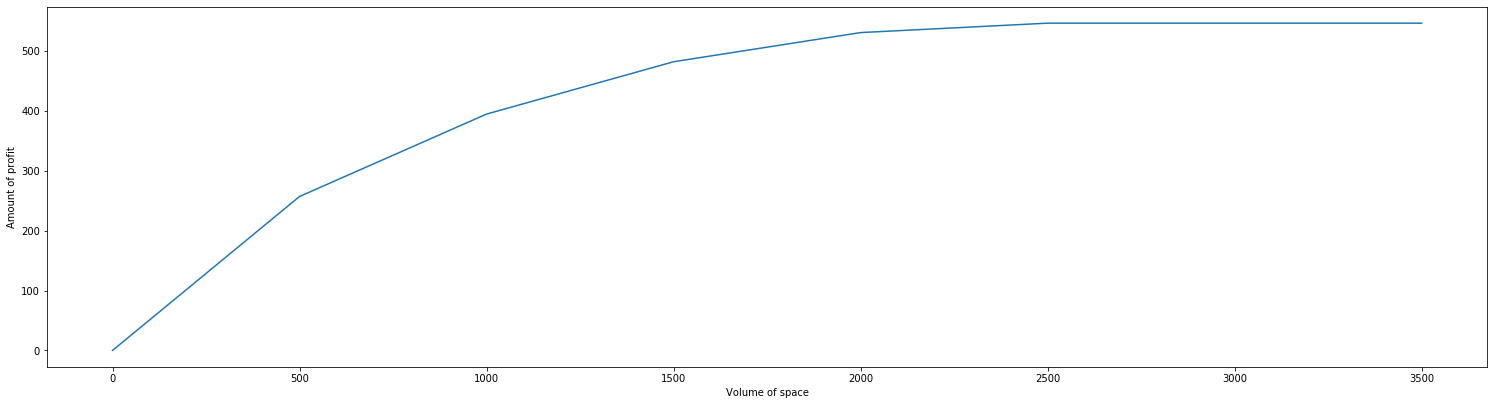

In [20]:
"""
Investigate relationship between space and profits
"""

x_volume_of_space = []
y_profit = []

for i in range(0, 5000, 500):
    x_volume_of_space.append(i)
    expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, i)
    y_profit.append(expected_amount_of_profit)
    
fig = plt.figure()
fig.set_size_inches(20, 5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Amount of profit')
ax.set_xlabel('Volume of space')
x = x_volume_of_space
y = y_profit
ax.plot(x,y)
plt.show()

In [21]:
"""
Testing with forecasted data from LSTM neural network
"""
total_space = 1000
demand = formatter_for_stochastic_optimizer(ingredient_demand_only_future, ingredient_demand_only_future, "demand")
expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, total_space)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0012s
Expected profit is: 175.76200000000009



Ingredient         Red & White Cabbage  Romaine  Kale  Baby Spinach  \
Quantity_to_order                  0.0      0.0   0.0          13.0   

Ingredient         Wholemeal Wrap  Spinach Wrap  Tortilla Wrap  Tomato Wrap  \
Quantity_to_order             0.0           0.0            0.0         10.0   

Ingredient         Cauliflower Rice  Quinoa  ...  Cashew Mint  Classic Caesar  \
Quantity_to_order               0.0     0.0  ...          0.0           189.0   

Ingredient         Honey Dijon  Lemon & Oil  Mixed Berries Vinaigrette  \
Quantity_to_order         15.0          0.0                        0.0   

Ingredient         Olive Oil  Salt & Pepper  Smoked Pimento  Smoky Ranch  \
Quantity_to_order       10.0           15.0             0.0          0.0   

Ingredient         Tabbasco Sauce  
Quantity_to_order            11.0  

[1 rows x 87 columns]